In [1]:
# import general libraries
import numpy as np
import os
from scipy.signal import periodogram
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.collections import LineCollection
# import from the file multiplayer_prisoners_dilemma.py
from multiplayer_prisoners_dilemma import QLearningAgent
from multiplayer_prisoners_dilemma import FreqAdjustedQLearningAgent
from multiplayer_prisoners_dilemma import FixedAgent
from multiplayer_prisoners_dilemma import TitForTatAgent
from multiplayer_prisoners_dilemma import SarsaAgent
from multiplayer_prisoners_dilemma import ExpSarsaAgent
from multiplayer_prisoners_dilemma import Game
from multiplayer_prisoners_dilemma import Simulation

# define the reward function for the two player prisoner's dilemma
def reward_matrix_for_two_player_PD(action_vector, player_id):
    action_tuple = tuple(action_vector)
    S, P, R, T = 0, 1, 3, 5
    reward_matrix = {
            (0, 0): (R, R),  # Both cooperate
            (0, 1): (S, T),  # Agent A defects, agent B cooperates
            (1, 0): (T, S),  # Agent A cooperates, agent B defects
            (1, 1): (P, P),  # Both cooperate
        }
    reward = reward_matrix[action_tuple]
    return reward[player_id]

# game parameters
num_players = 2
action_space = np.array([0 ,  1], dtype=float) # (0 = cooperate, 1 = defect)
observation_length = 0 # number of previous actions that are considered in the observation vector (0 = only current action)
use_prefactor = True

In [2]:
def calculate_fixed_point_policy(temperature, discount_factor, initial_guess = [0, 1], print_solution = True, print_additional_info = False):
    # define four-dimensional system of equations
    def equations(variables, T = temperature, discount_factor = discount_factor):
        a, b, c, d = variables

        eq1 = a - 1 / (np.exp(c/T) + np.exp(d/T)) * (3 * np.exp(c/T)) +\
            discount_factor * max(a,b)
        eq2 = b - 1 / (np.exp(c/T) + np.exp(d/T)) * (5 * np.exp(c/T) + np.exp(d/T)) +\
            discount_factor * max(a,b)
        eq3 = c - 1 / (np.exp(a/T) + np.exp(b/T)) * (3 * np.exp(a/T)) +\
            discount_factor * max(c,d)
        eq4 = d - 1 / (np.exp(a/T) + np.exp(b/T)) * (5 * np.exp(a/T) + np.exp(b/T)) +\
            discount_factor * max(c,d)

        return [eq1, eq2, eq3, eq4]

    # Initial guess for the solution
    a_init, b_init = initial_guess
    initial_guess = [a_init, b_init, a_init, b_init]

    # Solve the system numerically and get information
    result, infodict, ier, msg = fsolve(equations, initial_guess, full_output=True)
    a, b, c, d = result
    fixed_point_policy = np.exp(a/temperature) / (np.exp(a/temperature) + np.exp(b/temperature))

    # prints
    if print_solution:
        print("------------------------------------")
        print(f"Numerical Solution: Q^1_C = {a}, Q^1_D = {b}, Q^2_C = {c}, Q^2_D = {d}")
        print("Q^1_D - Q^1_C =", b - a)
        print(f"Fixed point policy at T={temperature} : ", fixed_point_policy)
        print("------------------------------------")
        print()

    if print_additional_info:
        # Additional information about the solution process
        print("\nSolution Process Information:")
        print("Number of iterations:", infodict['nfev'])
        print("fjac\n", infodict['fjac'])
        print("fvec\n", infodict['fvec'])
        print("r", infodict['r'])
        print("qtf", infodict['qtf'])
        print("Exit code:", ier)
        print("Exit message:", msg)

        # Zustandssumme: 
        N1 = np.exp(result[0]) + np.exp(result[1])
        N2 = np.exp(result[2]) + np.exp(result[3])
        print()
        print("Zustandssumme:")
        print("N1 =", N1)
        print("N2 =", N2)

        # Wahrscheinlichkeiten:
        print("Wahrscheinlichkeiten:")
        print("p1 =", np.exp(result[0]) / N1)
        print("p2 =", np.exp(result[1]) / N1)

    return fixed_point_policy

def calculate_target_Q_values(prob_to_coop_j, discount_factor, print_solution = False):
    # expected rewards for agent i
    Exp_Reward_C = 3 * prob_to_coop_j + 0 * (1. - prob_to_coop_j)
    Exp_Reward_D = 5 * prob_to_coop_j + 1 * (1. - prob_to_coop_j)

    # geometric series for agent i
    Q_max_C = Exp_Reward_C / (1 - discount_factor)
    Q_max_D = Exp_Reward_D / (1 - discount_factor)

    # target Q-values for agent j
    Q_target_C = Exp_Reward_C + discount_factor * max(Q_max_C, Q_max_D)
    Q_target_D = Exp_Reward_D + discount_factor * max(Q_max_C, Q_max_D)

    if print_solution:
        print("------------------------------------")
        print(f"For prob_to_coop_j = {prob_to_coop_j} and discount_factor = {discount_factor}, the target Q-values are:")
        print(f"Q_target_C = {Q_target_C}")
        print(f"Q_target_D = {Q_target_D}")
        print("------------------------------------")
        print()

    return np.array([Q_target_C, Q_target_D])

def generate_q_values(prob_to_coop, temperature, base_value):
    # Calculate the difference between Q-values
    delta_Q = temperature * np.log(1/prob_to_coop - 1) # difference between Q-values: delta_Q = Q_D - Q_C
    
    # Calculate Q_D and Q_C centered around the base value
    Q_D = base_value + delta_Q / 2
    Q_C = base_value - delta_Q / 2
    
    return np.array([[Q_C, Q_D]])

def calculate_next_probabilities(agents, initial_probabilities):
    reward_matrix_agent_0 = np.array([[agents[0].reward_func([i, j], agents[0].player_id) for j in range(2)] for i in range(2)])
    reward_matrix_agent_1 = np.array([[agents[1].reward_func([i, j], agents[1].player_id) for j in range(2)] for i in range(2)])

    # get learning rates and temperature of the agents
    learning_rate_agent_0 = agents[0].learning_rate
    learning_rate_agent_1 = agents[1].learning_rate
    temperature_agent_0 = agents[0].temperature
    temperature_agent_1 = agents[1].temperature

    next_probabilities_array = []
    for probabilities in initial_probabilities:
        prop_agent_0, prop_agent_1 = probabilities # prob to cooperate
        # construct probability vectors for both agents
        p_0_vector = np.array([prop_agent_0, 1 - prop_agent_0]) # prob to coop, prob to defect
        p_1_vector = np.array([prop_agent_1, 1 - prop_agent_1]) # prob to coop, prob to defect

        # intermediate calculations
        P_0_vector = p_0_vector * np.exp( learning_rate_agent_0 / temperature_agent_0 * (np.dot(reward_matrix_agent_0, p_1_vector) - temperature_agent_0 * np.log(p_0_vector)))
        P_1_vector = p_1_vector * np.exp( learning_rate_agent_1 / temperature_agent_1 * (np.dot(reward_matrix_agent_1.T, p_0_vector) - temperature_agent_1 * np.log(p_1_vector)))

        # calculate the next probabilities
        prop_agent_0_next = P_0_vector[0] / np.sum(P_0_vector) # expected prob to cooperate for agent 1 in next time step
        prop_agent_1_next = P_1_vector[0] / np.sum(P_1_vector) # expected prob to cooperate for agent 2 in next time step

        next_probabilities_array.append((prop_agent_0_next, prop_agent_1_next))
    
    return next_probabilities_array

# generate the simulation runs

In [3]:
# define the agents
agent_pair = [QLearningAgent, QLearningAgent]
discount_factor = 0.
learning_rate = 0.01
selection_method = "Boltzmann" 
temperature = 1

fixed_point_policy = calculate_fixed_point_policy(temperature, discount_factor, print_solution = False)
Q_target_C, Q_target_D = calculate_target_Q_values(fixed_point_policy, discount_factor)

base_value = np.round(0 / (1 - discount_factor), 1)
print(f"base_value: {base_value}")

# run simulation of the game for num_episodes
num_time_steps = int(3e3)
num_runs = 1
initial_probabilities = [(0.1, 0.9), (0.5, 0.9), (0.7,0.9), (0.9, 0.9), (0.9,0.7),
                        (0.1, 0.5), (0.5, 0.5), (0.9, 0.5),
                        (0.1, 0.1), (0.5, 0.1), (0.9, 0.1)]

# create storage for the mean prob_trajectories for each initial probability pair
trajectories_group_C = [] # index: number of initial probability pair
trajectories_group_C_size = [] # index: number of initial probability pair
trajectories_group_D = [] # index: number of initial probability pair
trajectories_group_D_size = [] # index: number of initial probability pair

# calculate the trajectories for the different initial probabilities. For each initial probability pair, the simulation is run num_runs times. 
# Each run is stored in the respective group. From the groups, the mean trajectory is calculated.
for initial_probability_pair in initial_probabilities:
    # set the initial Q-values
    initial_Q_tables = [generate_q_values(prob, temperature, base_value) for prob in initial_probability_pair]

    # Create a list of agents
    agents = [agent_pair[i](player_id = i, 
                    action_space = action_space,
                    num_players = num_players,
                    discount_factor = discount_factor,
                    observation_length = observation_length,
                    selection_method = selection_method,
                    reward_func = reward_matrix_for_two_player_PD,
                    q_table = initial_Q_tables[i],
                    temperature = temperature,
                    learning_rate = learning_rate,
                    use_prefactor = use_prefactor
                    )       
                    for i in range(num_players)]

    # Create a game and a Simulation
    game = Game(agents = agents)
    simulation = Simulation()

    # create storage for the probabilities of the different runs
    probabilities_runs_agents_group_C = [] # group which learned to coop.   first index: #run, second index: agent 
    probabilities_runs_agents_group_D = [] # group which learned to def.    first index: #run, second index: agent

    # Run the simulation num_runs times
    for run in range(num_runs):
        # Run the simulation
        simulation.run(game, agents, num_time_steps)
        # get probabilities
        probabilities_agents = [] # index: agent
        for agent in agents:
            prob_to_coop = np.array([agent.get_action_probabilities(q_table) for q_table in agent.q_table_history[:]])[:, 0, 0] # Extract the first entry of each 2D array
            probabilities_agents.append(prob_to_coop)
        # determine whether the joint policy is above or below the diagonal (1, 0) - (0, 1) and store the probabilities accordingly
        last_probability_pair = np.array([probabilities_agents[0][-1], probabilities_agents[1][-1]])
        if last_probability_pair[1] > (1 - last_probability_pair[0]): # above the diagonal
            probabilities_runs_agents_group_C.append(probabilities_agents)
        else: # below the diagonal
            probabilities_runs_agents_group_D.append(probabilities_agents)
    
    # get the average probabilities for the different groups
    # for group C
    if len(probabilities_runs_agents_group_C) > 0:
        probabilities_group_C = np.mean(probabilities_runs_agents_group_C, axis = 0)
    else:
        probabilities_group_C = None
    # for group D
    if len(probabilities_runs_agents_group_D) > 0:
        probabilities_group_D = np.mean(probabilities_runs_agents_group_D, axis = 0)
    else:
        probabilities_group_D = None
    
    # store the average probabilities for the different groups
    trajectories_group_C.append(probabilities_group_C)
    trajectories_group_D.append(probabilities_group_D)

    # store the relative size of the groups
    trajectories_group_C_size.append(len(probabilities_runs_agents_group_C) / num_runs)
    trajectories_group_D_size.append(len(probabilities_runs_agents_group_D) / num_runs)


base_value: 0.0


In [4]:
# save the data for reproducability
save_data = False
if save_data:
    # generate a dictionary with the data
    data = {
        "trajectories_group_C": trajectories_group_C,
        "trajectories_group_D": trajectories_group_D,
        "trajectories_group_C_size": trajectories_group_C_size,
        "trajectories_group_D_size": trajectories_group_D_size,
        "initial_probabilities": initial_probabilities
    }
    # generate the directory if it does not exist
    directory = os.path.join("data", "Flowplots")
    if not os.path.exists(directory):
        os.makedirs(directory)
    # save the dictionary
    np.save(os.path.join(directory, f"data_Qbase_{base_value}_numRuns_{num_runs}_numSteps_{num_time_steps}_{base_value}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), data)
    print("Data saved successfully.")

# plot the simulation runs

In [5]:
# retrieve the data for reproducability if load_data = True. Else, set load_data = False and continue with the data generated above
load_data = False
if load_data: 
    # set the parameters
    num_runs = 5
    num_time_steps = int(3e3)
    discount_factor = 0.
    base_value = np.round(0 / (1 - discount_factor),1)
    temperature = 1
    learning_rate = 0.01
    # load the data
    data = np.load(os.path.join("data", "Flowplots", f"data_Qbase_{base_value}_numRuns_{num_runs}_numSteps_{num_time_steps}_{base_value}_T_{temperature}_learningRate_{learning_rate}_y_{discount_factor}.npy"), allow_pickle=True).item()
    trajectories_group_C = data["trajectories_group_C"]
    trajectories_group_D = data["trajectories_group_D"]
    trajectories_group_C_size = data["trajectories_group_C_size"]
    trajectories_group_D_size = data["trajectories_group_D_size"]
    initial_probabilities = data["initial_probabilities"]
    print("Data loaded successfully.")

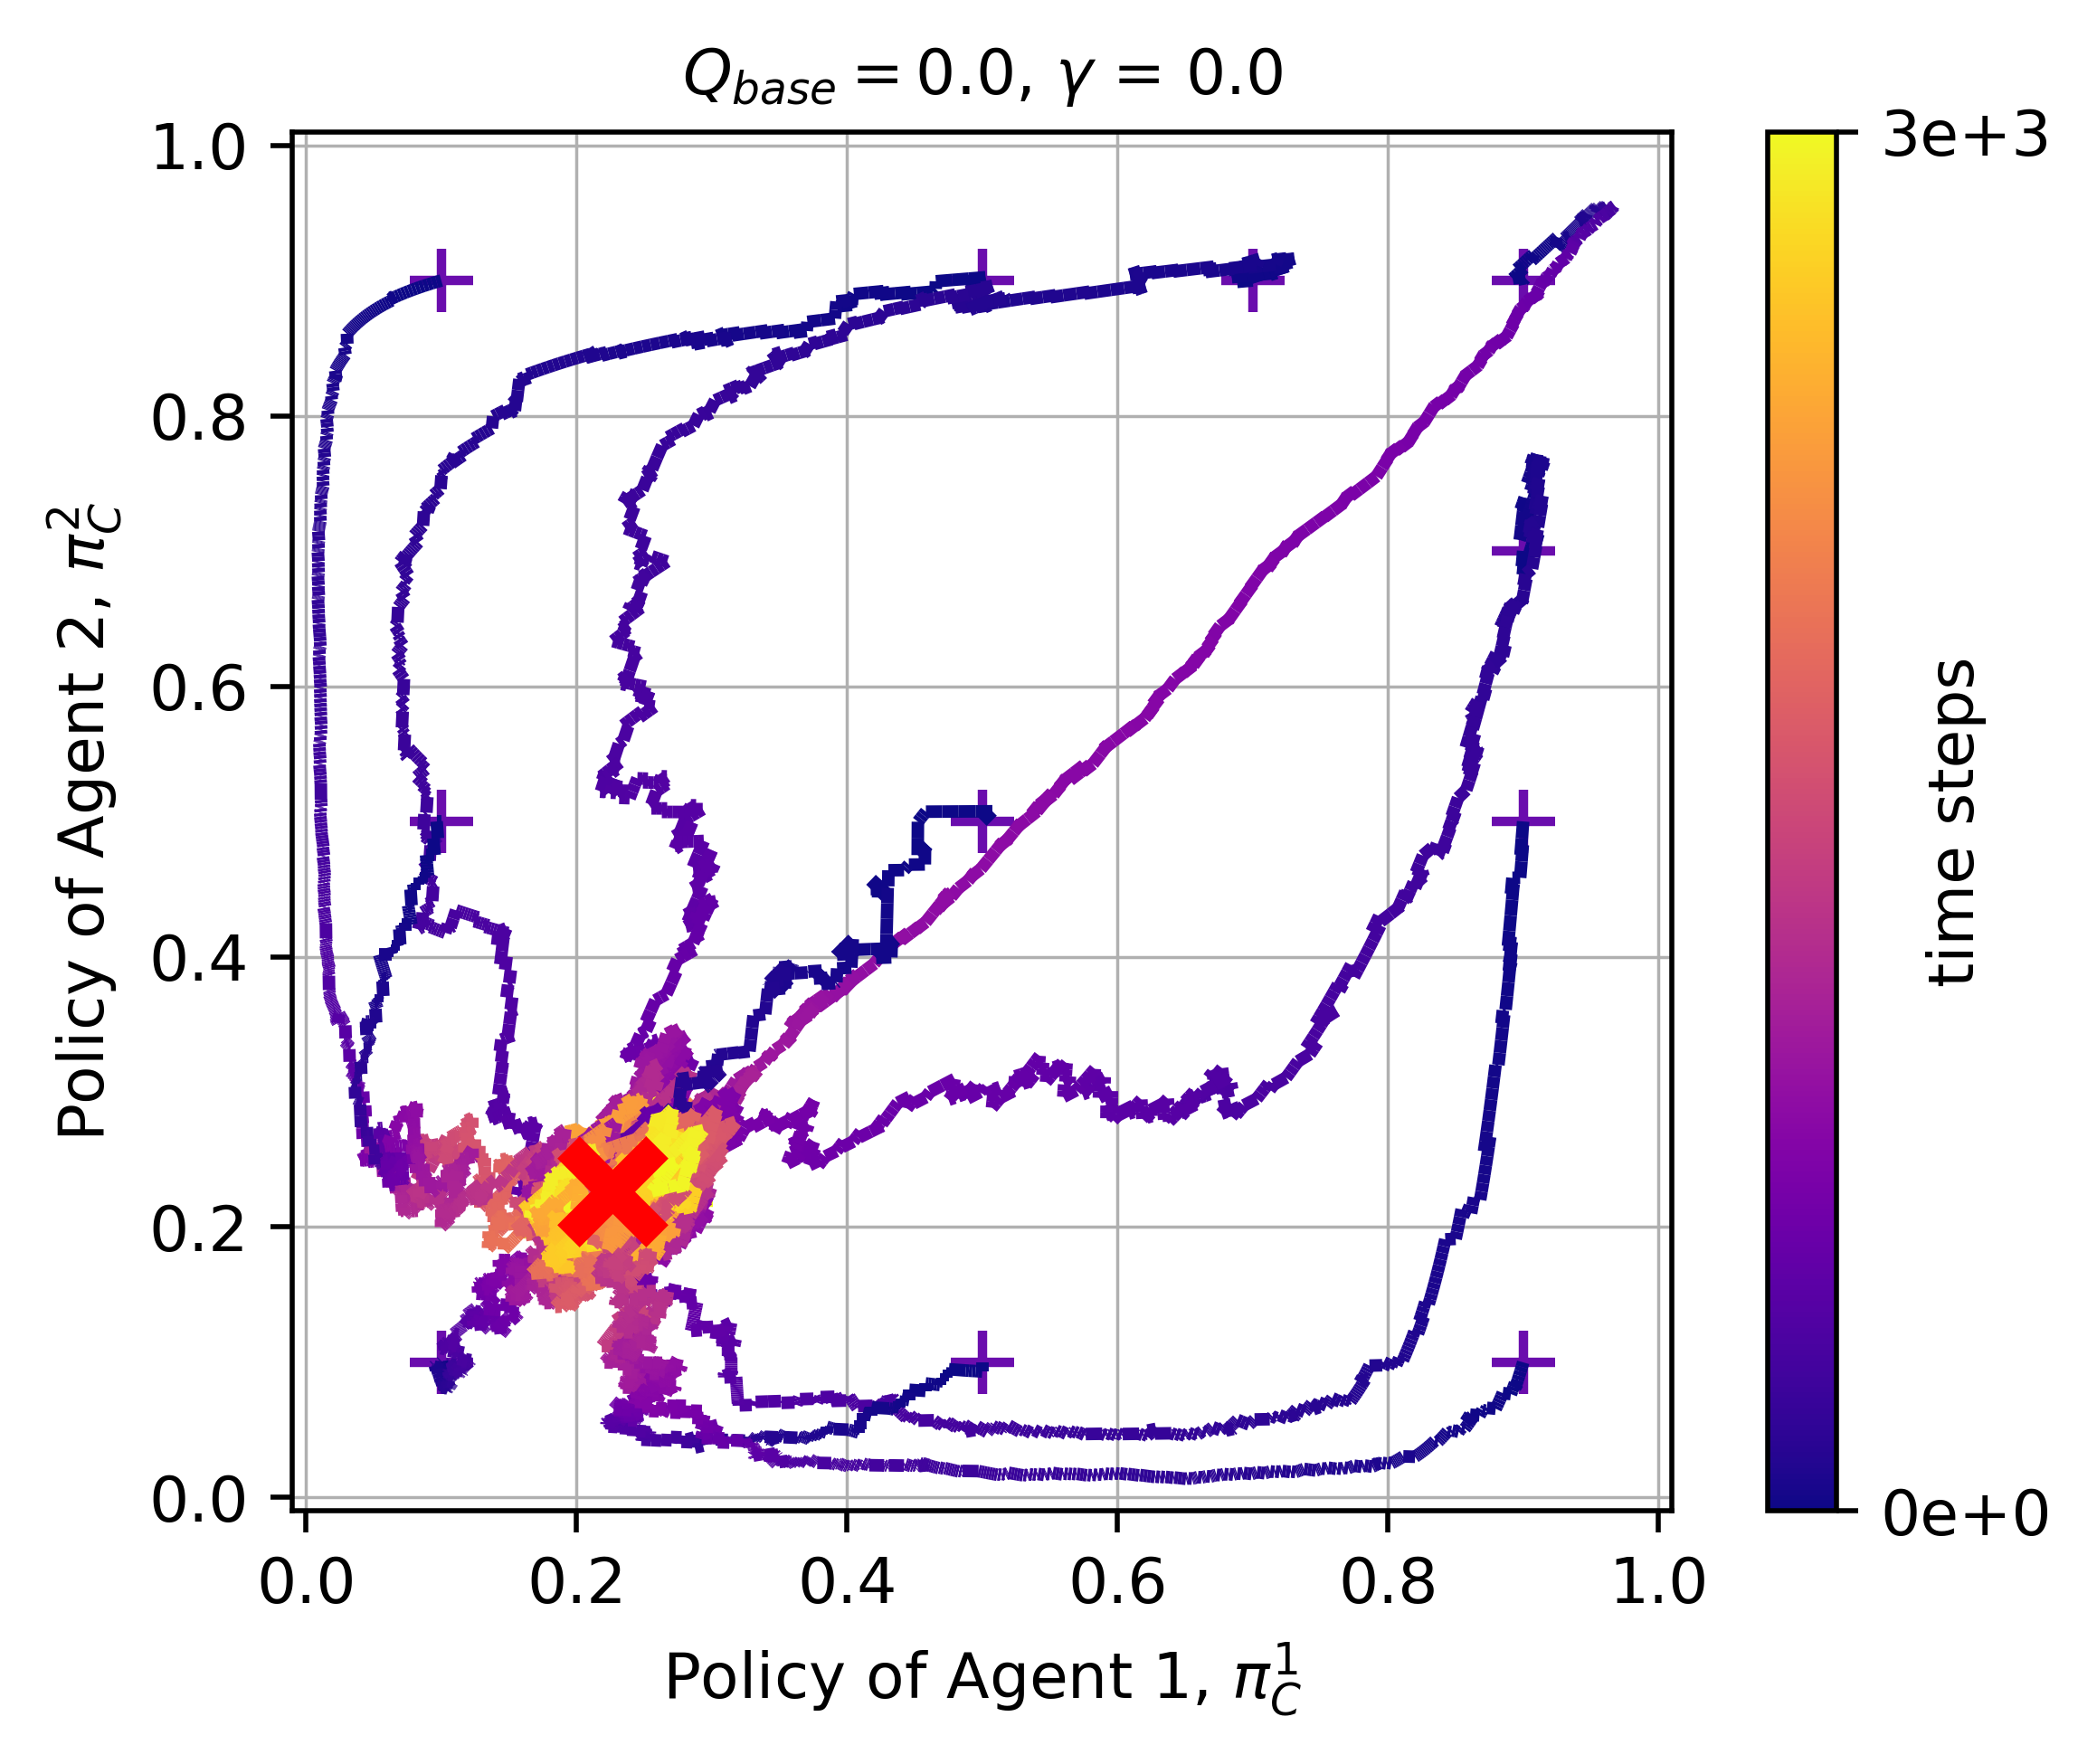

In [6]:
# plot the results
dpi = 500
figsize = (4, 4)
plt.figure(dpi=dpi)
start_marker_color = "#6a0dad"  # Hex code for a shade of dark purple
end_marker_color = plt.cm.plasma(1.0) # bright yellow
marker_size = 100
marker_size_2 = 200
fontsize = None

# calculate the arrows for the deterministic model of Barfuss et al. (2019)
if False:
    # Create a grid of initial arrow probabilities
    x = np.linspace(0.001, 0.999, 10)
    initial_arrow_probabilities = [(x[i], x[j]) for i in range(len(x)) for j in range(len(x))]
    # Calculate the next arrow probabilities
    next_arrow_probabilities = calculate_next_probabilities(agents, initial_arrow_probabilities)
    lengths = [np.sqrt((next_arrow_probabilities[i][0] - initial_arrow_probability[0])**2 + 
                    (next_arrow_probabilities[i][1] - initial_arrow_probability[1])**2) 
            for i, initial_arrow_probability in enumerate(initial_arrow_probabilities)]
    # Normalize the lengths to the range [0, 1]
    lengths = (lengths - np.min(lengths)) / (np.max(lengths) - np.min(lengths))
    # Plot the arrows
    for i, initial_arrow_probability in enumerate(initial_arrow_probabilities):
        dx = next_arrow_probabilities[i][0] - initial_arrow_probability[0]
        dy = next_arrow_probabilities[i][1] - initial_arrow_probability[1]
        direction_length = np.sqrt(dx**2 + dy**2)
        dx /= direction_length
        dy /= direction_length
        dx *= lengths[i] * 0.05
        dy *= lengths[i] * 0.05
        plt.arrow(initial_arrow_probability[0], initial_arrow_probability[1], dx, dy, 
            head_width=0.01, head_length=0.01, fc='black', ec='black')

# Fixed Point of deterministic model of Barfuss et al. (2019)
if True:  
    # Analyytical solution: 2D-equation system in policy space
    T1 = agents[0].temperature
    T2 = agents[1].temperature
    def equations(variables):
        x, y = variables
        eq1 = x - np.exp((y+5*(1-y))/T1) / ( np.exp((y+5*(1-y))/T1) + np.exp((3*(1-x))/T1) )
        eq2 = y - np.exp((x+5*(1-x))/T2) / ( np.exp((x+5*(1-x))/T2) + np.exp((3*(1-y))/T2) )
        if use_prefactor:
            eq1 = x - np.exp((y+5*(1-y))*(1-discount_factor)/T1) / ( np.exp((y+5*(1-y))*(1-discount_factor)/T1) + np.exp((3*(1-x))*(1-discount_factor)/T1) )
            eq2 = y - np.exp((x+5*(1-x))*(1-discount_factor)/T2) / ( np.exp((x+5*(1-x))*(1-discount_factor)/T2) + np.exp((3*(1-y))*(1-discount_factor)/T2) )
        return [eq1, eq2]
    initial_guess = [0, 0]
    # Solve the system numerically and get information
    prob_D_1_solution, prob_D_2_solution = fsolve(equations, initial_guess)
    prob_C_1_solution = 1 - prob_D_1_solution
    prob_C_2_solution = 1 - prob_D_2_solution
    analytical_solution_scatter = plt.scatter(prob_C_1_solution, prob_C_2_solution, c='red', marker='x', s=marker_size_2, linewidths=5, zorder=11)
    #plt.legend()

# plot the trajectories for both groups
for g, group in enumerate([trajectories_group_C, trajectories_group_D]):
    for i, trajectory in enumerate(group):
        if trajectory is not None:
            #plt.plot(trajectory[0], trajectory[1], label = f"Initial Probabilities: {initial_probabilities[i]}", alpha = 1)
            plt.scatter(trajectory[0][0], trajectory[1][0], color = start_marker_color, s = marker_size, marker='+')
            plt.scatter(trajectory[0][-1], trajectory[1][-1], color = end_marker_color, s = marker_size, marker='+')

            # Create a list of lines
            lines = [[(trajectory[0][j], trajectory[1][j]), (trajectory[0][j+1], trajectory[1][j+1])] for j in range(len(trajectory[0])-1)]
            # get the size of the lines
            size = 2 * [trajectories_group_C_size[i], trajectories_group_D_size[i]][g] # get the specific size of trajectory 
            # Create a line collection
            lc = LineCollection(lines, cmap='plasma', linewidths=size, alpha=1)
            # Set the colors of the lines
            lc.set_array(np.linspace(0, 1, num_time_steps))
            # Add the LineCollection to the plot
            plt.gca().add_collection(lc)

# plot colorbar for time evolution
if True:
    cbar = plt.colorbar(lc, fraction=0.046, pad=0.04)
    cbar.set_label('time steps', labelpad=-20, y=0.5)
    # lc is normalized so we need to set the ticks manually
    tick_values = [0, 1]
    cbar.set_ticks(tick_values)  # Set the ticks to the desired positions
    # Format tick labels into scientific notation manually
    tick_labels = [0, num_time_steps]
    tick_labels_scientific_notation = ["{:.0e}".format(tick_label) for tick_label in tick_labels]
    # Define a custom formatter to remove the leading zero in the exponent
    def custom_formatter(x):
        return f'{x:.0e}'.replace('e+0', 'e+').replace('e-0', 'e-')
    tick_labels_scientific_notation_reduced = [custom_formatter(tick_label) for tick_label in tick_labels]
    cbar.set_ticklabels([tick_label for tick_label in tick_labels_scientific_notation_reduced])
# set the title
title = (r'$Q_{base} =$' + f'{base_value:.1f}, ' + f'$\\gamma$ = {discount_factor}')
plt.title(title, wrap=True, horizontalalignment='center', fontsize=fontsize)
plt.xlabel("Policy of Agent 1, $\pi^1_C$")
plt.ylabel("Policy of Agent 2, $\pi^2_C$")
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
# set axis to be equal
plt.gca().set_aspect('equal', adjustable='box')
# add grid
plt.grid(linewidth=0.5)
# save the figure
plt.tight_layout()
plt.savefig(f"Figures/PaperFigures/Fig2_I_discount_{discount_factor}_Qbase_{base_value}_temp_{temperature}__learningRate_{learning_rate}_numTimeSteps_{num_time_steps}_numRuns_{num_runs}.jpg", dpi=dpi, bbox_inches='tight')
plt.show()
